# Hipotesis: cuando menor competencia hay en una categoria de Mercado Libre mayores son las ganancias

hip. inspirada en el libro "De cero a uno", Peter Thiel

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json
from pandas.io.json import json_normalize
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/categoriasmeli/response (4).json


# Primero necesito la competencia y el codigo de cada categoria

In [2]:
raw_data = pd.read_json("../input/categoriasmeli/response (4).json")
print(raw_data.shape)
raw_data.head()


(13, 10010)


,MLA86379,MLA6520,MLA417044,MLA455985,MLA1512,MLA442346,MLA5725,MLA86360,MLA434708,MLA1403,...,MLA73686,MLA73695,MLA413766,MLA413764,MLA2787,MLA2785,MLA414179,MLA413765,MLA2779,MLA2788
id,MLA86379,MLA6520,MLA417044,MLA455985,MLA1512,MLA442346,MLA5725,MLA86360,MLA434708,MLA1403,...,MLA73686,MLA73695,MLA413766,MLA413764,MLA2787,MLA2785,MLA414179,MLA413765,MLA2779,MLA2788
name,Alarmas para Motos,Accesorios de Auto y Camioneta,Accesorios Náuticos,Bombas y Filtros de Agua,Agro,Animales,Accesorios para Vehículos,Accesorios para Camiones,Alforjas,Alimentos y Bebidas,...,Otros,Medias,Pezoneras,Polleras,Portaligas,Tangas,Trajes de Baño,Vestidos,Lencería Femenina,Otros
picture,https://http2.mlstatic.com/storage/categories-...,https://http2.mlstatic.com/storage/categories-...,None,None,https://http2.mlstatic.com/storage/categories-...,None,https://http2.mlstatic.com/storage/categories-...,https://http2.mlstatic.com/storage/categories-...,None,https://http2.mlstatic.com/storage/categories-...,...,None,None,None,None,None,None,None,None,None,None
permalink,None,None,None,None,https://www.mercadolibre.com.ar/c/agro,None,https://www.mercadolibre.com.ar/c/accesorios-p...,None,None,https://www.mercadolibre.com.ar/c/alimentos-y-...,...,None,None,None,None,None,None,None,None,None,None
total_items_in_this_category,581,230035,5870,524,13707,136,8896906,14890,2760,411698,...,38,183,114,41,337,559,100,216,3499,268


# La competencia es la cantidad de items en cada categoria

total_items_in_this_category

In [3]:
raw_data.loc['total_items_in_this_category'].sort_values(ascending=False).head()

MLA3025      9616295
MLA412445    9091138
MLA5725      8896906
MLA1747      7324530
MLA1574      2564289
Name: total_items_in_this_category, dtype: object

In [10]:
competencia = raw_data.loc['total_items_in_this_category'].sort_values(ascending=True)

# Obtengo la clave para hacer las llamadas a la API de Mercado Libre

In [1]:
url = "https://api.mercadolibre.com/oauth/token"
rT = '****'
# rToken = 'TG-63bb85767f30c50001341eae-611928415'
payload='grant_type=refresh_token&client_id=****&client_secret=****&refresh_token='+rT
headers = {
  'accept': 'application/json',
  'content-type': 'application/x-www-form-urlencoded'
}

response = requests.request("POST", url, headers=headers, data=payload)
JO = json.loads(response.text)
rT = JO['refresh_token']
aT = JO['access_token']
print(response.text)

NameError: name 'requests' is not defined

# Voy a tomar por cada categoria a los items mas vendidos, voy a multiplicar la cantidad vendida por el precio sumo toda la ganancia de los 10 items y luego divido en diez. Asi consigo un promedio de ganancia para cada categoria

In [18]:
#################################### Asi obtengo los items de cada categoria

url = "https://api.mercadolibre.com/highlights/MLA/category/MLA373468"

payload={}
headers = {
  'Authorization': 'Bearer '+aT
}

highlights = requests.request("GET", url, headers=headers, data=payload)

# print(highlights.text)
l = json.loads(highlights.text)['content']
# [0]['type']
itemsL= []
prodL = []
index = 0
for i in l:
    if i['type'] == 'ITEM':
        itemsL.append(i);
    if index == 10:
        break
    index = index+1

itemsL

[{'id': 'MLA1139790530', 'position': 1, 'type': 'ITEM'},
 {'id': 'MLA1273966473', 'position': 2, 'type': 'ITEM'},
 {'id': 'MLA904626614', 'position': 3, 'type': 'ITEM'},
 {'id': 'MLA609877492', 'position': 4, 'type': 'ITEM'},
 {'id': 'MLA758022256', 'position': 5, 'type': 'ITEM'},
 {'id': 'MLA886633860', 'position': 6, 'type': 'ITEM'},
 {'id': 'MLA897933544', 'position': 7, 'type': 'ITEM'},
 {'id': 'MLA896772814', 'position': 8, 'type': 'ITEM'},
 {'id': 'MLA644071171', 'position': 9, 'type': 'ITEM'},
 {'id': 'MLA913112031', 'position': 10, 'type': 'ITEM'},
 {'id': 'MLA1148598356', 'position': 11, 'type': 'ITEM'}]

In [19]:
######################################## Haciendo esta llamada obtengo informacion sobre la cantidad 'sold_quantity'
######################################## y sobre el precio 'price'
url = "https://api.mercadolibre.com/items?ids=MLA1139790530"

payload={}
headers = {
  'Authorization': 'Bearer '+ rT
}

items = requests.request("GET", url, headers=headers, data=payload)
items = json.loads(items.text)


[{'code': 200,
  'body': {'id': 'MLA1139790530',
   'site_id': 'MLA',
   'title': 'Buje Para Pedal De Bomba Embrague Citroen C3 C4 Peugeot 208',
   'subtitle': None,
   'seller_id': 709617392,
   'category_id': 'MLA373468',
   'official_store_id': None,
   'price': 2199,
   'base_price': 2199,
   'original_price': None,
   'currency_id': 'ARS',
   'initial_quantity': 178,
   'available_quantity': 1,
   'sold_quantity': 150,
   'sale_terms': [{'id': 'WARRANTY_TIME',
     'name': 'Tiempo de garantía',
     'value_id': None,
     'value_name': '1 meses',
     'value_struct': {'number': 1, 'unit': 'meses'},
     'values': [{'id': None,
       'name': '1 meses',
       'struct': {'number': 1, 'unit': 'meses'}}],
     'value_type': 'number_unit'},
    {'id': 'WARRANTY_TYPE',
     'name': 'Tipo de garantía',
     'value_id': '2230280',
     'value_name': 'Garantía del vendedor',
     'value_struct': None,
     'values': [{'id': '2230280',
       'name': 'Garantía del vendedor',
       'struct

In [56]:
################################### ordeno de mayor competencia a menor competencia
competencia = raw_data.loc['total_items_in_this_category'].sample(n=1000, random_state=1).sort_values(ascending=False)
competencia

MLA5725      8896906
MLA1574      2564289
MLA1132       859775
MLA61177      331895
MLA377699     284527
              ...   
MLA454868          0
MLA445777          0
MLA456297          0
MLA446793          0
MLA456342          0
Name: total_items_in_this_category, Length: 1000, dtype: object

In [25]:
n=0
competenciaL = [] ################# Listas para guardar los datos sobre competencia, ganancia, unidades y categoria
gananciaL = []
unidadL = []
categoriaL = []
for c in competencia:
    comp = competencia[n]    ################ Cantidad de items en la categoria
    categoria = competencia[[n]].index[0]############# Codigo de la categoria
    print(categoria,comp)
    competenciaL.append(comp)
    categoriaL.append(categoria)
    n = n+1
    
     ########### llamada para obtener los mejores en la categoria
    url = "https://api.mercadolibre.com/highlights/MLA/category/"+categoria 
    payload={}
    headers = {
      'Authorization': 'Bearer '+aT
    }
    highlights = requests.request("GET", url, headers=headers, data=payload)
    highlights = json.loads(highlights.text)
    if 'content' in highlights:
        l = highlights['content']

    itemsL= []

    nItems = 0
    for i in l:
        if i['type'] == 'ITEM':
            itemsL.append(i);
        nItems = nItems+1
    
    cantTot =[]
    CP=[]
    for i in itemsL:#########################Por cada item hago una llamada
        ################################para obtener la ganancia y la cantidad
        url = "https://api.mercadolibre.com/items?ids="+i['id']
        payload={}
        headers = {
          'Authorization': 'Bearer '+ rT
        }
        items = requests.request("GET", url, headers=headers, data=payload)
        items = json.loads(items.text)
        precio = items[0]['body']['price']
        cant = items[0]['body']['sold_quantity']
        cantTot.append(cant)
        CP.append( cant*precio)
    ganancia = sum(CP)/nItems############### Promedio la ganancia entre los items de la categoria 
    gananciaL.append(ganancia)
    unidades = sum(cantTot)/nItems############### Promedio las cantidades de venta entre los items de la categoria 
    unidadL.append(unidades)
    print(ganancia, int(unidades))



MLA5725 8896906
12447497.5 3888
MLA1574 2564289
30165966.0 5626
MLA1132 859775
9678546.985 2033
MLA61177 331895
1331645.025 154
MLA377699 284527
3101382.1774999998 496
MLA1635 239539
1819157.8865000003 511
MLA109027 195978
20953564.702 4821
MLA11830 176208
3083877.625 992
MLA5337 139537
3603874.565 2100
MLA1744 132556
3603874.565 2100
MLA30088 107556
15489199.854999999 4270
MLA4611 94462
5589471.1 753
MLA388848 91587
852065.5 159
MLA1613 85335
5559601.5 1407
MLA2061 75549
532747.325 152
MLA454379 74433
180652.25 75
MLA373427 71672
394240.3275 43
MLA1432 70781
1944773.4125 610
MLA373048 66373
1781804.25 205
MLA60900 60417
1932169.05 102
MLA85998 57792
2807246.2625 265
MLA454690 53912
6283290.0 730
MLA414251 50663
8104907.392999999 1294
MLA86006 50030
95645.52249999999 54
MLA375040 49267
179761.62799999997 72
MLA388973 36334
1129970.6875 170
MLA1576 35733
845169.825 195
MLA105179 34073
845169.825 195
MLA1166 33300
2906434.8364999997 1082
MLA374225 31626
268019.0875 83
MLA455425 29961
866

JSONDecodeError: Expecting value: line 1 column 21 (char 20)

# Ahora voy a averiguar la relacion entre competencia y ganancia

In [31]:
cL = competenciaL
catL = categoriaL

In [32]:
cL = cL[:-1]###################### 
catL = catL[:-1]

In [33]:
d = {'competencia': cL, 'ganancia': gananciaL,'unidades': unidadL}
df = pd.DataFrame(data=d, index=catL) ################ creo un dataframe
df

,competencia,ganancia,unidades
MLA5725,8896906,1.244750e+07,3888.000000
MLA1574,2564289,3.016597e+07,5626.000000
MLA1132,859775,9.678547e+06,2033.500000
MLA61177,331895,1.331645e+06,154.000000
MLA377699,284527,3.101382e+06,496.950000
...,...,...,...
MLA439586,557,2.831165e+05,32.636364
MLA429028,553,5.762004e+04,21.300000
MLA433707,547,2.718838e+06,301.250000
MLA455926,545,2.146230e+05,291.600000


In [34]:
df.to_pickle("./gVc.pkl")  ############ Guardo en un pkl

# Analisis grafico

<AxesSubplot:xlabel='competencia'>

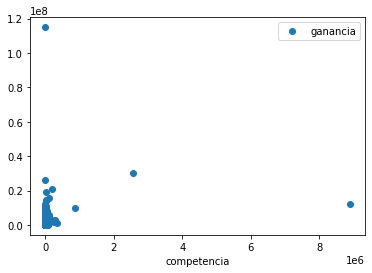

In [37]:
df.plot(x='competencia', y='ganancia', style='o')

<AxesSubplot:xlabel='competencia'>

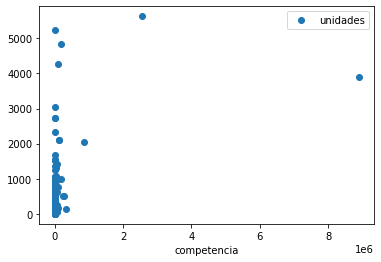

In [36]:
df.plot(x='competencia', y='unidades', style='o')

# A poca competencia las cantidades que se venden son en su mayoria pequeñas. Una alta competencia en Mercado Libre es que la cantidades de unidades que hay que vender son muy grandes. Sobre las ganancias esta grafica solo dice que si estas entre los mejores en una categoria muy competente las ganancias estan entre las mas altas

# Voy a sacar los puntos extremos de competencia para ver si encuentro otro patron

In [38]:
df2 = df.iloc[2:]

<AxesSubplot:xlabel='competencia'>

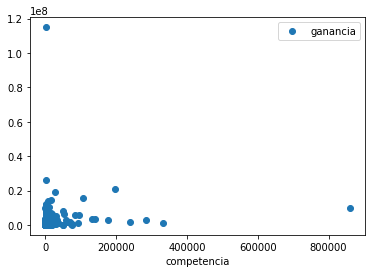

In [40]:
df2.plot(x='competencia', y='ganancia', style='o')

<AxesSubplot:xlabel='competencia'>

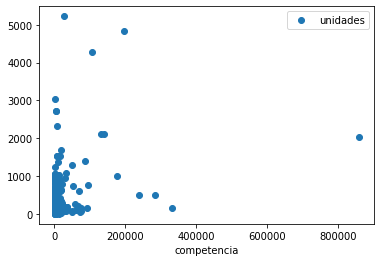

In [39]:
df2.plot(x='competencia', y='unidades', style='o')

Se puede observar que con menor competencia la cantidad que se vende es menor. La cantidad de ventas que tenes que hacer para tener la misma ganancia es relativamente grande en categorias de alta competencia 

In [43]:
df3 = df.iloc[20:] #### quito 20 datos de alta competencia 

<AxesSubplot:xlabel='competencia'>

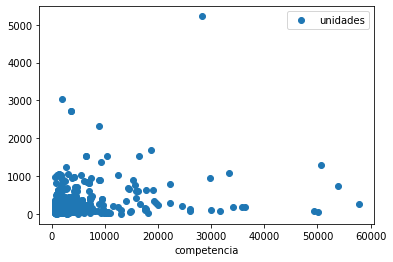

In [44]:
df3.plot(x='competencia', y='unidades', style='o')

<AxesSubplot:xlabel='competencia'>

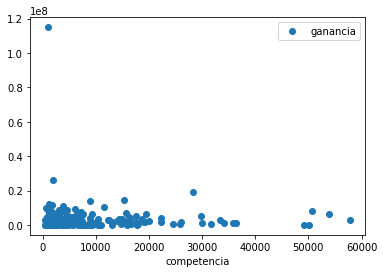

In [45]:
df3.plot(x='competencia', y='ganancia', style='o')

# vale la pena analizar si a mayor competencia mayores ganancias

In [47]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

ajustamos df3

In [49]:
X = df3[["competencia"]]
y = df3[["ganancia"]]
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

predecimos...

In [50]:
y_pred = regr.predict(X)

graficamos

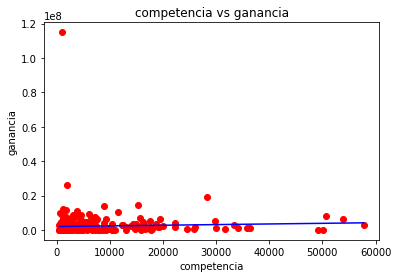

In [52]:
plt.scatter(X, y, color = 'red')
plt.plot(X, regr.predict(X), color = 'blue')
plt.title('competencia vs ganancia')
plt.xlabel('competencia')
plt.ylabel('ganancia')
plt.show()

In [54]:
print("Coeficiente: \n", regr.coef_)

Coeficiente: 
 [[37.18896564]]


# serian unos 37 pesos mas por cada competidor que se suma 